In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide'] < 200]

cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

data['boolQuality'] = 0
data['boolQuality'][data['quality']>5] = 1

/var/folders/85/j2qtn7190hzcnyrjdrk1grc80000gn/T/ipykernel_25019/3563048514.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality']>5] = 1


In [4]:
dataT = torch.tensor(data[cols2zscore].values).float()
labels = torch.tensor(data['boolQuality'].values).float()
labels = labels[:, None]

In [5]:
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size=.1)

train_data = torch.utils.data.TensorDataset(train_data, train_labels)
test_data = torch.utils.data.TensorDataset(test_data, test_labels)

batchSize = 32
train_loader = DataLoader(train_data, batch_size=batchSize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [20]:
class ANNwine(nn.Module):
    def __init__(self, actfun):
        super().__init__()
        self.input = nn.Linear(11, 16)
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 32)
        self.output = nn.Linear(32,1)
        self.actfun = actfun

    def forward(self, x):
        actfun = getattr(torch.nn, self.actfun)
        x = actfun()(self.input(x))
        x = actfun()(self.fc1(x))
        x = actfun()(self.fc2(x))
        return self.output(x)

In [21]:
net = ANNwine('ReLU')
net(torch.randn(10,11)).shape

torch.Size([10, 1])

In [11]:
numEpochs = 1000

def trainTheModel():
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(params=winenet.parameters(), lr=0.01)

    losses = torch.zeros(numEpochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numEpochs):
        winenet.train()

        batchAcc =[]
        batchLoss = []

        for X, y in train_loader:
            yHat = winenet(X)

            loss = lossfun(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append(100*torch.mean(((yHat>0)==y).float()).item())

        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)

        winenet.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = winenet(X)
        testAcc.append(100*torch.mean(((yHat>0)==y).float()).item())

    return trainAcc, testAcc, losses

In [12]:
activation_funcs = ['relu', 'tanh', 'sigmoid']

trainByAct = np.zeros((numEpochs, len(activation_funcs)))
testByAct = np.zeros((numEpochs, len(activation_funcs)))

for ai, act_func in enumerate(activation_funcs):
    winenet = ANNwine(act_func)
    trainByAct[:, ai], testByAct[:, ai], losses = trainTheModel()

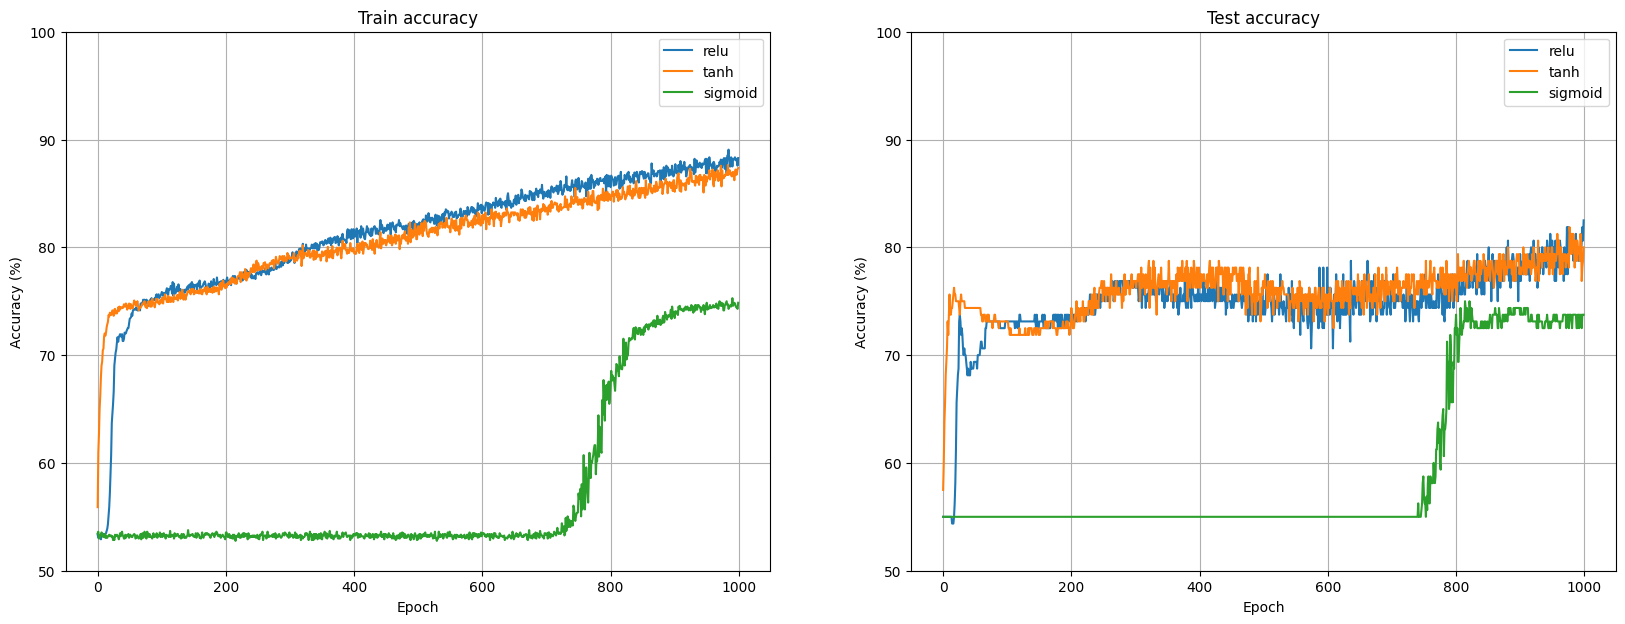

In [13]:
fig,ax = plt.subplots(1,2,figsize=(20,7))

ax[0].plot(trainByAct)
ax[0].set_title('Train accuracy')
ax[1].plot(testByAct)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].legend(activation_funcs)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,100])
  ax[i].grid()

plt.show()